# Setup

In [ ]:
%pip install kornia==0.4.0
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import kornia as K
from PIL import Image
import glob
import os
import csv

In [ ]:
your_path = ''
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/'+your_path
import sys
sys.path.append(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## GPU

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  DEVICE = 'cpu'
  print('CUDA is not available.  Training on CPU ...')
else:
  DEVICE = 'cuda'
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## DATA analysis

### Define transforms

In [ ]:
from datasets.utils.transforms import ToGray, ToTensor, Rescale

### Dataset model

In [ ]:
from datasets.COCO.COCO_model import *

### Get dataset

In [ ]:
# create image name csv
import glob
import csv

def sortKeyFunc(s):
    return int(s[5:-4])

lst = glob.glob(path+'/datasets/video_data/video3_images/*')
lst = sorted([os.path.basename(x) for x in lst], key=sortKeyFunc)

names = np.array([[x] for x in lst])
print(len(names))
filename = path+'/datasets//video_data/video3_names.csv'
with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    head = np.array([['im_name']])
    csvwriter.writerows(head)
    csvwriter.writerows(names)



283


In [ ]:
BATCH_SIZE = 5

# Download the data
transform = transforms.Compose([ToTensor()]) 


dataset = COCO_dataset(path+'/datasets//video_data/video3_names.csv',path+'/datasets/video_data/video3_images', transform=transform, landmark_bool=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
batch = next(iter(dataloader))

print(len(dataset))
print(len(dataloader))


283
57


### Check dataloader

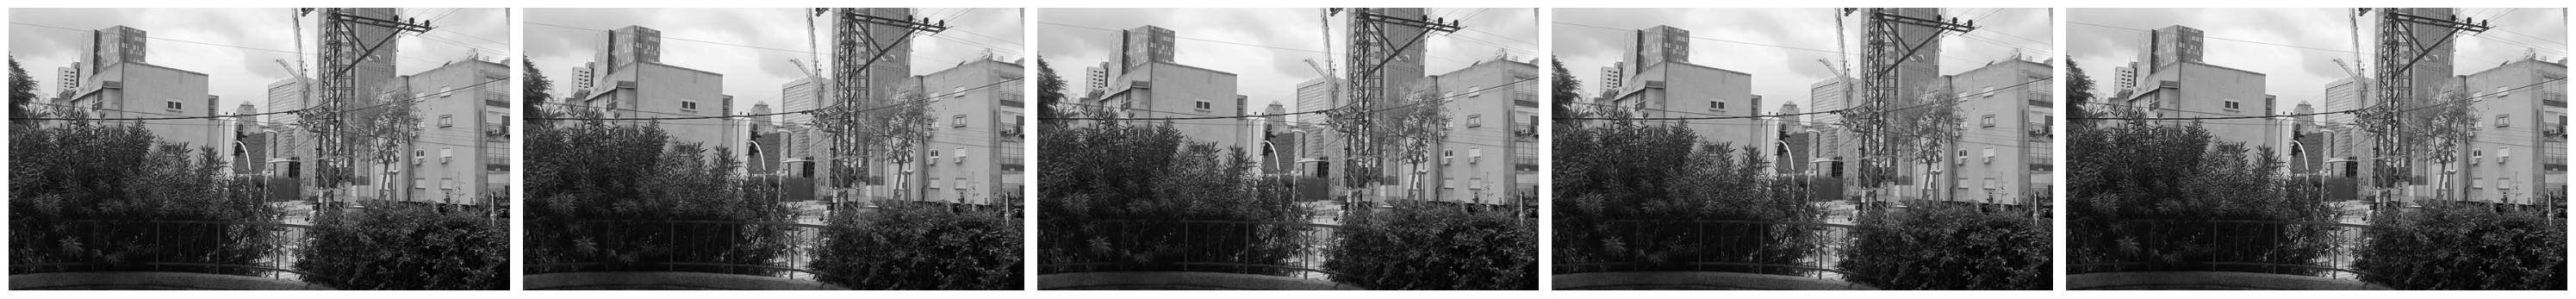

In [ ]:
import kornia as K
from utils.plot import plot_imgs

im = batch[0]
im = K.tensor_to_image(im)
plot_imgs(im)

# Network

## Superpoint model

In [ ]:
from models.superpoint import SuperPointNet

## load pretrained model

In [ ]:
superpoint_bool = False
model = SuperPointNet(superpoint_bool=superpoint_bool).to(DEVICE)

weights_path = path+'/pretrained_weights/superpoint_v1.pth' 
model.load_state_dict(torch.load(weights_path))
model.eval()


SuperPointNet(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d

## Help functions

In [ ]:
from utils.points import map_to_cords, nms, get_prob_map

In [ ]:
def is_cude():
  device = 'cuda' if torch.cuda.is_available() else 'cpu' 
  return device

## label function

In [ ]:
import time
def write_labels(model, dataset,  data_path, saving_path, BATCH_SIZE=10, n_points=300):
  t_0 = time.time()
  DEVICE = is_cude()
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
  names = np.array([[os.path.basename(x)] for x in glob.glob(data_path+'/*')]) 
  filename = saving_path
  with open(filename, 'w') as csvfile:  
      #creating a csv writer object  
      csvwriter = csv.writer(csvfile)
      #write headline
      head = np.array(['x{},y{},conf{}'.format(i,i,i).split(',') for i in range(n_points)]).reshape((1,-1))
      head = np.concatenate((np.array([['im_name']]),head), axis=1)
      csvwriter.writerows(head)
      model.eval()
      for iter, (im,label) in enumerate(dataloader):
        with torch.no_grad():
          #sample data
          image_tens = im.type(torch.float32).to(DEVICE)
          h=im.size()[2]
          w=im.size()[3]

          
          #put warps through net 
          semi, desc = model.forward(image_tens)
          map = get_prob_map(semi)
          map[:,:,0:5,0] = 0
          map[:,:,:,0:7] = 0
          map[:,:,-5:,:] = 0
          map[:,:,:,-7:] = 0

          #get points
          points = nms(map, 5, topk = n_points)

          #set coordinates for saving
          new_cords = map_to_cords(BATCH_SIZE=BATCH_SIZE, iter=iter, points=points, names=names) 

          # writing the data rows  
          csvwriter.writerows(new_cords)

          if iter%5 == 0:
            t_f = time.time()
            minute = (t_f-t_0)/60
            print('iteration {}/{} is runing... {} minutes passed'.format(iter,len(dataloader),minute))
        

# Run

In [ ]:
write_labels(model, dataset,  path+'/datasets/video_data/video3_images', path+'/datasets/video_data/video3_images_labels.csv', BATCH_SIZE=1, n_points=300)

iteration 0/283 is runing... 0.0005141337712605794 minutes passed
iteration 5/283 is runing... 0.002118058999379476 minutes passed
iteration 10/283 is runing... 0.0034559488296508787 minutes passed
iteration 15/283 is runing... 0.004779644807179769 minutes passed
iteration 20/283 is runing... 0.006222673257191976 minutes passed
iteration 25/283 is runing... 0.0076356927553812666 minutes passed
iteration 30/283 is runing... 0.008951934178670247 minutes passed
iteration 35/283 is runing... 0.0102294127146403 minutes passed
iteration 40/283 is runing... 0.011506887276967366 minutes passed
iteration 45/283 is runing... 0.012874265511830648 minutes passed
iteration 50/283 is runing... 0.014173762003580729 minutes passed
iteration 55/283 is runing... 0.01560517946879069 minutes passed
iteration 60/283 is runing... 0.017033231258392335 minutes passed
iteration 65/283 is runing... 0.018305885791778564 minutes passed
iteration 70/283 is runing... 0.019581210613250733 minutes passed
iteration 75

# test

(392, 696)


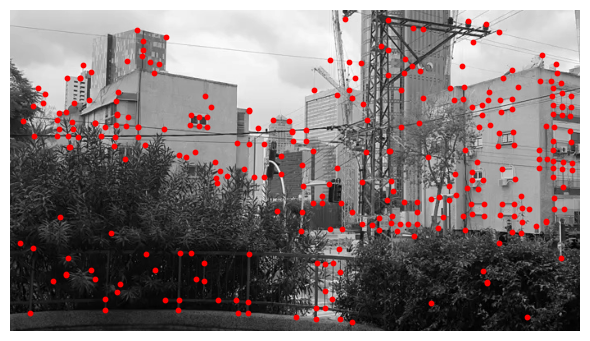

In [ ]:
BATCH_SIZE = 1

# Download the data
transform = transforms.Compose([ToTensor()]) 


dataset = COCO_dataset(path+'/datasets//video_data/video3_images_labels.csv',path+'/datasets/video_data/video3_images',transform=transform , landmark_bool=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
batch = next(iter(dataloader))
im = K.tensor_to_image(batch[0])
print(im.shape)
im = im.reshape(1,im.shape[0],im.shape[1])
label = batch[1]
label = label.unsqueeze(1)
plot_imgs(im,label=label)